In [1]:
import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot
import pycbc as pycbc
from pycbc import frame
import os, glob
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.getcwd()
# full fidelity, 16 KHz data: 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf'
# downsamplesd, 4 kHz data: 'data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf'
fs = glob.glob('data/O1/*gwf')
print(fs)

['data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126256640-4096.gwf']


In [3]:
f = fs[0]
f = fs[-1]
f = fs[1]
print(f)
print(get_channel_names(f))
kdq, kinj, kdata = get_channel_names(f)

print(kdq, kinj, kdata)

data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf
['H1:GWOSC-16KHZ_R1_DQMASK', 'H1:GWOSC-16KHZ_R1_INJMASK', 'H1:GWOSC-16KHZ_R1_STRAIN']
H1:GWOSC-16KHZ_R1_DQMASK H1:GWOSC-16KHZ_R1_INJMASK H1:GWOSC-16KHZ_R1_STRAIN


In [4]:
tmin = 1126252544 + 33*60
deltat = 2*60#32#0.015
#deltat = 0.015 # will not contain glitch but useful for quick debugging
tmax = tmin + deltat

#series = TimeSeries.read(f, kdata)
series = TimeSeries.read(f, kdata, start=tmin, end=tmax)
series_dq = TimeSeries.read(f, kdq, start=tmin, end=tmax)
series_inj = TimeSeries.read(f, kinj, start=tmin, end=tmax)

In [5]:
print(series)
print(series.sample_rate)
print(series.t0)
print(series.dt)
print(len(series))
print(deltat/series.dt.value)

TimeSeries([-7.02876685e-20, -1.30403523e-19, -1.31728163e-19,
            ..., -3.05143821e-19, -3.32713738e-19,
            -3.28899054e-19]
           unit: dimensionless,
           t0: 1126254524.0 s,
           dt: 6.103515625e-05 s,
           name: H1:GWOSC-16KHZ_R1_STRAIN,
           channel: H1:GWOSC-16KHZ_R1_STRAIN)
16384.0 Hz
1126254524.0 s
6.103515625e-05 s
1966080
1966080.0


# Plot time series

In [6]:
def plot_series(series, xlims=None, ylims=None, title='time series'):
    plot = series.plot(title='LIGO-Hanford, %s'%(title), ylabel='Amplitude [strain]', color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

Look at quality flag  
**NOTE:** seems to be too simplistic--just tells you whether data was taken or not. More detailed status available from DQ channel of gwf file, as in following cell.

In [7]:
'''
from gwpy.segments import DataQualityFlag
segs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)
plot = segs.plot(color='gwpy:ligo-hanford')
plot.show()
'''

"\nfrom gwpy.segments import DataQualityFlag\nsegs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)\nplot = segs.plot(color='gwpy:ligo-hanford')\nplot.show()\n"

Inspect quality flags from DQ channel of gwf file itself. The flags are set in 1 s intervals only.  
**0**:DATA, **1**:CBC_CAT1, **2**:CBC_CAT2, **3**:CBC_CAT3, **4**:BURST_CAT1, **5**:BURST_CAT2, **6**:BURST_CAT3  
An integer value of `127` denotes highest DQ tier (CBC_CAT3), and `63` denotes second DQ tier (CBC_CAT2)  
**IMPORTANT:** Passing the highest DQ tier does **not** mean the data is glitch-free  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [8]:
'''
# Uncomment to print out individual bits
nDQbits = 7
# get int32-converted bits
bits = series_dq.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual DQ bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnDQbits = 7\n# get int32-converted bits\nbits = series_dq.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual DQ bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]\n    print(i, bit, bitvals)\n'

The same can be done for the injection bits, which say whether or not there was an injected signal, and if so, of which kind  
An integer value of 31 means there was no injected signal of any kind.  
**0**:NO_CBC_HW_INJ **1**:NO_BURST_HW_INJ **2**:NO_DETCHAR_HW_INJ **3**:NO_CW_HW_INJ **4**:NO_STOCH_HW_INJ  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [9]:
'''
# Uncomment to print out individual bits
nInjbits = 5
# get int32-converted bits
bits = series_inj.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual injection bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnInjbits = 5\n# get int32-converted bits\nbits = series_inj.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual injection bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]\n    print(i, bit, bitvals)\n'

Make time series plots of data, DQ status, and injection status

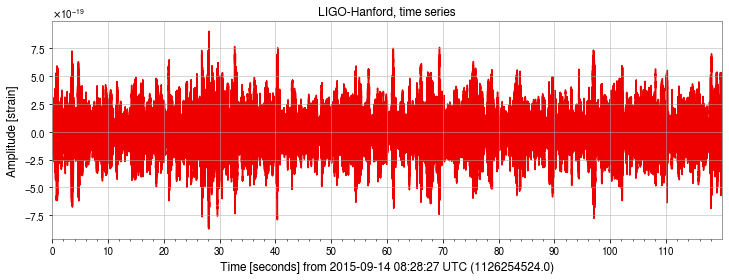

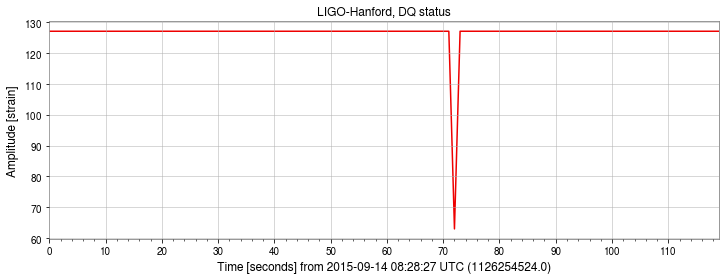

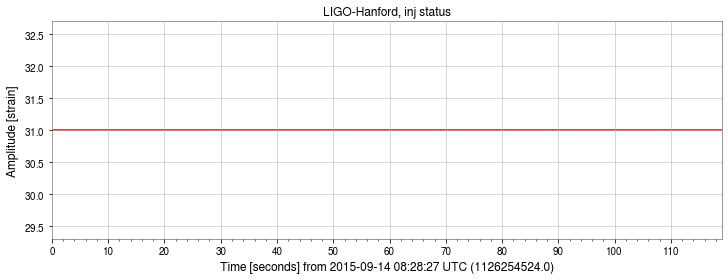

In [10]:
plot_series(series)
plot_series(series_dq, title='DQ status')
plot_series(series_inj, title='inj status')

Look at frequency domain

In [11]:
def plot_asd(series, xlims=None, ylims=None):
    asd = series.asd()
    plot = asd.plot(title='LIGO-Hanford, amplitude spectral density (ASD)', ylabel=r'ASD [$\sqrt{Hz}$]', color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

def plot_psd(series, xlims=None, ylims=None):
    psd = series.psd()
    plot = psd.plot(title='LIGO-Hanford, power spectral density (PSD)', ylabel=r'PSD [Hz]', color='gwpy:ligo-hanford')
    #plot.axes[1].set_ylim(1e-20, 1e-15)
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()
    psd.show()

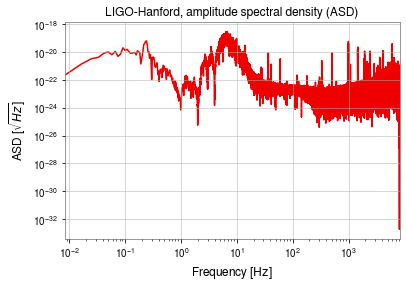

In [12]:
plot_asd(series)

However, O1 data is not calibrated below 10 Hz or above 5 kHz (2 kHz for data at 4 kHz), so apply low pass and high pass filter, a.k.a., bandpass filter:  
Ref: https://www.gw-openscience.org/O1/

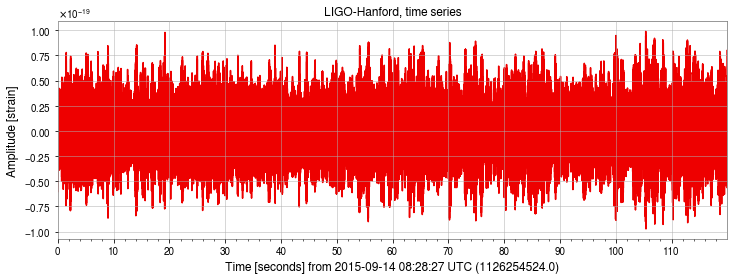

In [13]:
fcalib_lo, fcalib_hi = 10., 2.e3 # Hz
series = series.bandpass(fcalib_lo, fcalib_hi) # or .highpass(fcalib_lo).lowpass(fcalib_hi)
plot_series(series)

Look at frequency domain again

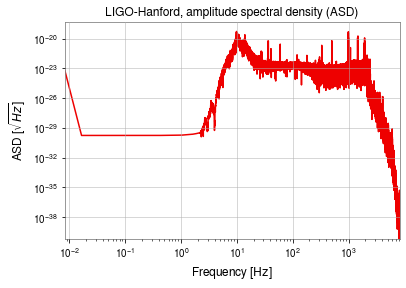

In [14]:
plot_asd(series)

Zoom in on bandpassed range

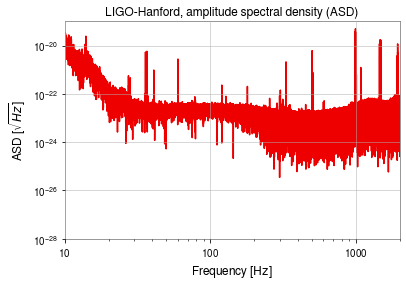

In [15]:
plot_asd(series, xlims=[fcalib_lo, fcalib_hi], ylims=[1.e-28, 1.e-19])

# Whiten data
Normalize to power density spectrum

In [16]:
def _fft_length_default(dt):
    # from https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/timeseries/timeseries.py#L44
    """Choose an appropriate FFT length (in seconds) based on a sample rate
    Parameters
    ----------
    dt : `~astropy.units.Quantity`
        the sampling time interval, in seconds
    Returns
    -------
    fftlength : `int`
        a choice of FFT length, in seconds
    """
    return int(max(2, np.ceil(2048 * dt)))

def whiten_series(series):
    # pycbc
    # pycbc does truncation by default
    # comparing: https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L1669
    # and https://pycbc.org/pycbc/latest/html/gw150914.html?highlight=whiten + https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    #series_pycbc = series.to_pycbc()
    #wht = series_pycbc.whiten(series.duration.value, _fft_length_default(series.dt.value))
    #wht = TimeSeries.from_pycbc(wht)
    # gwpy
    wht = series.whiten()
    # truncate corrupted ends
    # from: https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    max_filter_duration = _fft_length_default(series.dt.decompose().value)
    max_filter_len = int(max_filter_duration * series.sample_rate.decompose().value)
    wht = wht[int(max_filter_len/2):-int(max_filter_len/2)]
    return wht

1933312


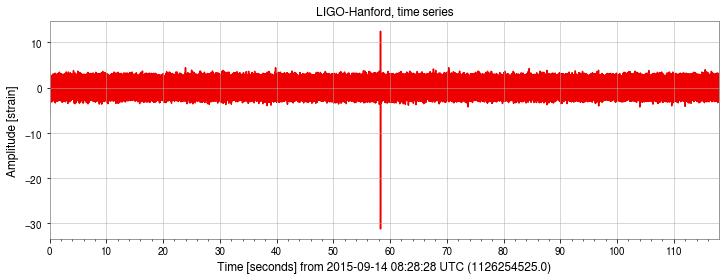

In [17]:
wht = whiten_series(series)
plot_series(wht)
print(len(wht))

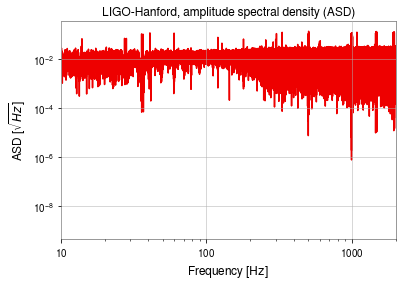

In [18]:
plot_asd(wht, xlims=[fcalib_lo, fcalib_hi])#, ylims=[1.e-28, 1.e-19])

Apply basic analysis-level bandpass  
Different refs use different ranges, but in general, should be optimized to frequency spectrum of signal  
Refs: https://www.gw-openscience.org/tutorial_bandpass/, https://pycbc.org/pycbc/latest/html/gw150914.html, https://gwpy.github.io/docs/stable/examples/signal/gw150914.html

In [19]:
fsg_lo, fsg_hi = 35., 250. # Hz
'''
# Uncomment to apply basic bandpass filter only
wht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)
plot_series(wht)
'''

'\n# Uncomment to apply basic bandpass filter only\nwht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)\nplot_series(wht)\n'

Alternatively, chain (1) bandpass and (2) notch removal at harmonics of AC power supply (60 Hz, 120 Hz, 180 Hz, ...), into a single ZPK filter    
Ref: https://gwpy.github.io/docs/stable/examples/signal/gw150914.html, https://pycbc.org/pycbc/latest/html/gw150914.html

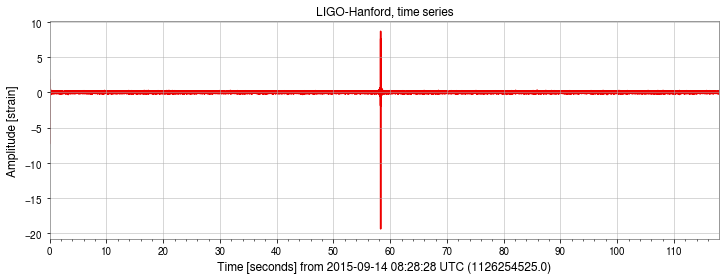

In [20]:
#'''
# define bandpass
bp = filter_design.bandpass(fsg_lo, fsg_hi, series.sample_rate)
# define notches
notches = [filter_design.notch(line, series.sample_rate) for line in (60, 120, 180)]
# chain filters
zpk = filter_design.concatenate_zpks(bp, *notches)
# set filtfilt=True to filter both backwards and forwards to preserve the correct phase at all frequencies
# see also: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter
wht = wht.filter(zpk, filtfilt=True)
plot_series(wht)
#'''

Note that this does **not** coincide with the drop in DQ tier.

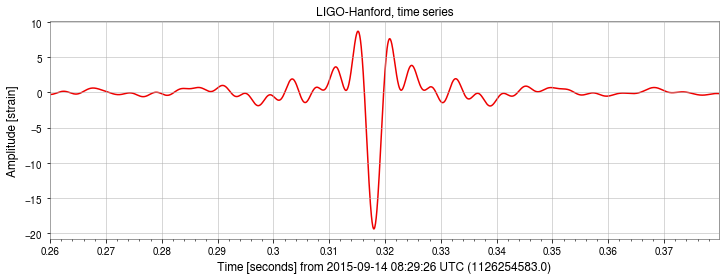

In [21]:
first = 1126254525+58+0.2+0.06
last = first+0.12
plot_series(wht.crop(first, last))

In [24]:
def plot_qt(qt, xlims=None, ylims=None):
    plot = qt.plot(title='LIGO-Hanford, Q-transform spectrogram', yscale='log')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()

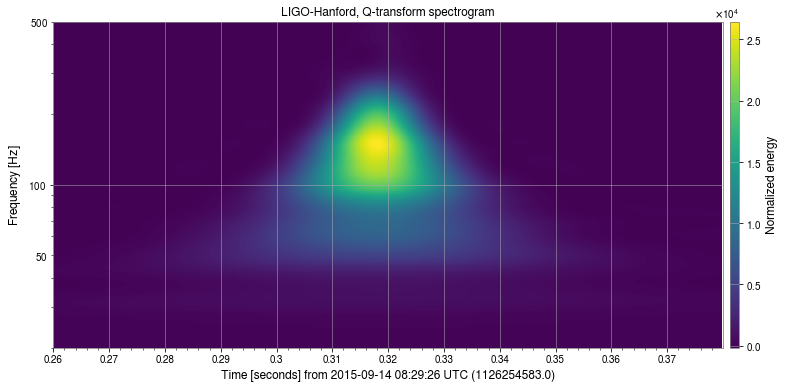

In [25]:
qt = wht.q_transform(outseg=(first, last))
plot_qt(qt, ylims=[20, 500])